In [1]:
import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.layers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import sys
import heapq
import seaborn as sns
from pylab import rcParams

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 12, 5

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [23]:
path = 'HP2.txt'
text = open(path).read().lower()
print('corpus length:', len(text))

corpus length: 21938


In [24]:
chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

print("unique chars:", len(chars))

unique chars: 40


In [25]:
SEQUENCE_LENGTH = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - SEQUENCE_LENGTH, step):
    sentences.append(text[i: i + SEQUENCE_LENGTH])
    next_chars.append(text[i + SEQUENCE_LENGTH])
print('num training examples:' ,len(sentences))

num training examples: 7300


In [26]:
X = np.zeros((len(sentences), SEQUENCE_LENGTH, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [27]:
sentences[99]

'a firm called grunnings, which made dril'

In [28]:
next_chars[99]

'l'

In [29]:
#One HOT
X[0][0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

In [30]:
#Output
y[0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

In [31]:
X.shape

(7300, 40, 40)

In [32]:
y.shape

(7300, 40)

In [33]:
model = Sequential()
model.add(LSTM(128, input_shape=(SEQUENCE_LENGTH, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               86528     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                5160      
_________________________________________________________________
activation_2 (Activation)    (None, 40)                0         
Total params: 91,688
Trainable params: 91,688
Non-trainable params: 0
_________________________________________________________________


In [34]:
###Model has been trained separately and the model was saved ###
model = load_model('keras_model5.h5')
history = pickle.load(open("history5.p", "rb"))

/usr/local/lib/python3.5/dist-packages/keras/layers/recurrent.py:2209: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  return cls(**config)
/usr/local/lib/python3.5/dist-packages/keras/layers/recurrent.py:2209: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(input_dtype="float32", trainable=True, recurrent_dropout=0.0, unit_forget_bias=True, return_sequences=False, recurrent_regularizer=None, stateful=False, recurrent_initializer="orthogonal", input_shape=(None, 40), batch_input_shape=[None, 40,..., kernel_initializer="glorot_uniform", bias_regularizer=None, name="lstm_1", unroll=False, go_backwards=False, implementation=0, recurrent_activation="hard_sigmoid", kernel_regularizer=None, activation="tanh", units=128, dropout=0.0)`
  return cls(**config)
/usr/local/lib/python3.5/dist-packages/keras/layers/recurrent.py:2068: UserWarning: `implementation=0` has been deprecated, and now defaults to `impl

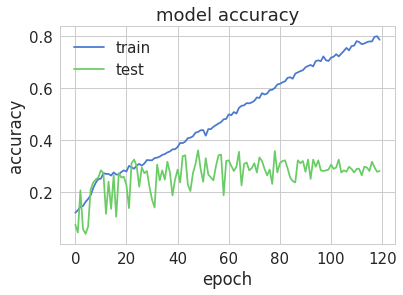

In [35]:
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

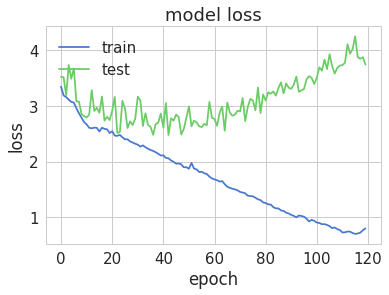

In [36]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

In [37]:
def prepare_input(text):
    x = np.zeros((1, 40, len(chars)))

    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
        
    return x

In [38]:
prepare_input("This is an example of input for our LSTM".lower())

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [39]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [40]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]

        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

In [41]:
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

In [42]:
quotes = ["Mr. Dursley was the director of a firm called Grunnings, which made drills. He was a big, beefy man with hardly any neck, although he did have a very large mustache.",
"At half past eight, Mr. Dursley picked up his briefcase, pecked Mrs. Dursley on the cheek, and tried to kiss Dudley good-bye but missed,"
,"he'd gotten into terrible trouble for being found on the roof of the school kitchens"]

In [43]:
for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()

mr. dursley was the director of a firm c
['lout... ', 'er ', 'as ', 'houlded ', 'it ']

at half past eight, mr. dursley picked u
['itew ', 'phow ', 'she ', 'moffed ', 'whordind ']

he'd gotten into terrible trouble for be
['chouddare. ', 'lhed ', 'theded ', 'eked ', 'kne ']

